Credit https://www.kaggle.com/jsylas/riiid-lgbm-starter

Import data and do pre-preprocessing

In [1]:
# Used most of coding from this kernel https://www.kaggle.com/lgreig/simple-lgbm-baseline

import riiideducation
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")
train = train[train.content_type_id == False]
#arrange by timestamp


train = train.sort_values(['timestamp'], ascending=True)

train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

In [2]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

In [3]:
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                            usecols=[0,1, 3,4],
                            dtype={'question_id': 'int16',
                              'part': 'int8','bundle_id': 'int8','tags': 'str'}
                          )
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 

In [4]:
#reading in question df
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [5]:
X = train.iloc[80000000:,:]
X['prior_question_had_explanation'].fillna(False, inplace=True)
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c, on=['content_id'], how="left")
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)
X

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,row_id,user_id,content_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,answered_correctly_content,question_id,bundle_id,part,tags,tags1,tags2,tags3,tags4,tags5,tags6
2969848,1232,13134,12263,500,3,10000.0,True,0.706356,878.0,0.570648,12263,-25,2,138 41 81 92,138.0,41.0,81.0,92.0,NaN,NaN
4342675,1702,13134,12115,902,1,19000.0,True,0.706356,878.0,0.809202,12115,83,2,143 140 38 81,143.0,140.0,38.0,81.0,NaN,NaN
4342647,1701,13134,12257,901,0,22000.0,True,0.706356,878.0,0.820975,12257,-31,2,90 100 92 29,90.0,100.0,92.0,29.0,NaN,NaN
4342609,1700,13134,12236,900,1,18000.0,True,0.706356,878.0,0.720157,12236,-52,2,155 163 92 29,155.0,163.0,92.0,29.0,NaN,NaN
5217369,1833,13134,13063,1008,1,29666.0,True,0.706356,878.0,0.960396,13063,5,4,136 103 81,136.0,103.0,81.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900539,101227967,2147419988,6872,229,0,46000.0,True,0.507671,364.0,0.650877,6872,-43,6,26 162,26.0,162.0,NaN,NaN,NaN,NaN
900540,101227966,2147419988,6870,229,0,46000.0,True,0.507671,364.0,0.382613,6870,-43,6,27 162,27.0,162.0,NaN,NaN,NaN,NaN
1025731,101228070,2147419988,7772,280,3,73800.0,True,0.507671,364.0,0.790899,7772,90,7,145 42 35 146 122,145.0,42.0,35.0,146.0,122.0,NaN
329605,101227886,2147419988,10040,191,1,39500.0,True,0.507671,364.0,0.588553,10040,54,6,53,53.0,NaN,NaN,NaN,NaN,NaN


In [6]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
X.head()

X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']] 
X.fillna(0.5,  inplace=True)
X.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,answered_correctly_user,answered_correctly_content,sum,bundle_id,part,prior_question_elapsed_time,prior_question_had_explanation_enc,tags1,tags2,tags3
2969848,0.706356,0.570648,878.0,-25,2,10000.0,1,138.0,41.0,81.0
4342675,0.706356,0.809202,878.0,83,2,19000.0,1,143.0,140.0,38.0
4342647,0.706356,0.820975,878.0,-31,2,22000.0,1,90.0,100.0,92.0
4342609,0.706356,0.720157,878.0,-52,2,18000.0,1,155.0,163.0,92.0
5217369,0.706356,0.960396,878.0,5,4,29666.0,1,136.0,103.0,81.0


In [7]:
import gc
del train
gc.collect()

52

In [8]:
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size =0.2, shuffle=False)

import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 600,
    'learning_rate': 0.02,
    'num_leaves': 80
}


lgb_train = lgb.Dataset(Xt, Yt,categorical_feature = ['part','tags1','tags2','tags3'])
lgb_eval = lgb.Dataset(Xv, Yv, reference=lgb_train,categorical_feature = ['part','tags1','tags2','tags3'])

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=10000,
    early_stopping_rounds=10
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.59896	valid_1's binary_logloss: 0.599032
[20]	training's binary_logloss: 0.579808	valid_1's binary_logloss: 0.579728
[30]	training's binary_logloss: 0.566495	valid_1's binary_logloss: 0.566294
[40]	training's binary_logloss: 0.557104	valid_1's binary_logloss: 0.556807
[50]	training's binary_logloss: 0.550406	valid_1's binary_logloss: 0.550034
[60]	training's binary_logloss: 0.545583	valid_1's binary_logloss: 0.545148
[70]	training's binary_logloss: 0.54209	valid_1's binary_logloss: 0.541609
[80]	training's binary_logloss: 0.539543	valid_1's binary_logloss: 0.539034
[90]	training's binary_logloss: 0.537675	valid_1's binary_logloss: 0.537148
[100]	training's binary_logloss: 0.53629	valid_1's binary_logloss: 0.535759
[110]	training's binary_logloss: 0.535257	valid_1's binary_logloss: 0.534728
[120]	training's binary_logloss: 0.534481	valid_1's binary_logloss: 0.533954
[130]	training's binary_log

[1070]	training's binary_logloss: 0.528994	valid_1's binary_logloss: 0.530523
[1080]	training's binary_logloss: 0.52898	valid_1's binary_logloss: 0.530518
[1090]	training's binary_logloss: 0.528964	valid_1's binary_logloss: 0.530521
Early stopping, best iteration is:
[1080]	training's binary_logloss: 0.52898	valid_1's binary_logloss: 0.530518


In [9]:
y_pred = model.predict(Xv)
y_true = np.array(Yv)
roc_auc_score(y_true, y_pred)

0.758125641528751

In [10]:
gc.collect()

622

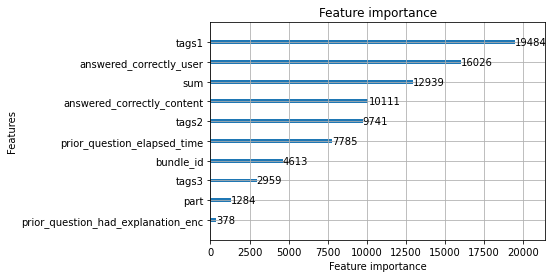

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
#displaying the most important features
lgb.plot_importance(model)
plt.show()

In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
    test_df['answer_time'] = test_df.groupby(['user_id'])['prior_question_elapsed_time'].shift(1)
    
    test_df = pd.merge(test_df, results_u, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_c, on=['content_id'],  how="left")    
    test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')    
    test_df['answered_correctly_user'].fillna(0.5, inplace=True)
    test_df['answered_correctly_content'].fillna(0.5, inplace=True)
    test_df['sum'].fillna(0, inplace=True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc',
                                                           'tags1','tags2','tags3']])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])